In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 80 (delta 19), reused 11 (delta 11), pack-reused 55
Receiving objects: 100% (80/80), 174.68 KiB | 966.00 KiB/s, done.
Resolving deltas: 100% (29/29), done.


Repo: https://github.com/time-series-foundation-models/lag-llama/

Paper: https://arxiv.org/abs/2310.08278

In [ ]:
%ls

lag-llama/  sample_data/


In [ ]:
%cd lag-llama/
%ls

/content/lag-llama
data/  gluon_utils/  images/  lag_llama/  LICENSE  README.md  requirements.txt


In [ ]:
!pip install -r requirements.txt --quiet # tome tiempo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmp8plat4dv
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 122MB/s]
/content/lag-llama/lag-llama.ckpt


In [ ]:
%ls

data/  gluon_utils/  images/  lag_llama/  lag-llama.ckpt@  LICENSE  README.md  requirements.txt


In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    #ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [73]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


In [74]:
df.dtypes

target     float64
item_id     object
dtype: object

In [75]:
df.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-01-10 14:00:00', '2021-01-10 15:00:00',
               '2021-01-10 16:00:00', '2021-01-10 17:00:00',
               '2021-01-10 18:00:00', '2021-01-10 19:00:00',
               '2021-01-10 20:00:00', '2021-01-10 21:00:00',
               '2021-01-10 22:00:00', '2021-01-10 23:00:00'],
              dtype='datetime64[ns]', length=2400, freq=None)

In [ ]:
df.query("item_id =='A'")

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,0.7328,A
2021-01-10 20:00:00,0.4957,A
2021-01-10 21:00:00,-0.1209,A
2021-01-10 22:00:00,-0.5072,A


In [ ]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

In [ ]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

In [ ]:
len(forecasts)

10

In [ ]:
forecasts[0].samples.shape

(100, 24)

In [ ]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id='A', samples=array([[-0.8076998 , -0.78988916, -0.8949956 , ...,  1.1850384 ,
          1.0355421 ,  0.60837233],
        [-0.4006002 , -0.28024265, -0.23470074, ...,  0.37973133,
          0.3102072 ,  0.1684683 ],
        [-0.88680893, -1.1532614 , -1.3532538 , ...,  0.83135754,
          0.53252655,  0.13042818],
        ...,
        [-0.68365407, -0.9483867 , -0.97790927, ...,  0.07993694,
         -0.4832491 , -0.89786786],
        [-0.88969964, -0.99510616, -1.0109496 , ..., -0.01719571,
         -0.319429  , -0.5422776 ],
        [-0.7070405 , -0.9334869 , -1.4987328 , ...,  0.45425615,
          0.0177755 , -0.33190754]], dtype=float32), start_date=Period('2021-01-10 00:00', 'H')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='B', samples=array([[ 0.17448686,  0.07020438,  0.03082722, ...,  0.62253815,
          0.50347275,  0.36827546],
        [ 0.2532088 ,  0.2260836 ,  0.13455324, ...,  0.56307584,
     

In [ ]:
print(forecasts[0].item_id)
print(forecasts[0].samples.shape)
print(forecasts[0].samples) # 100 muestras de distirbucion para el forecast

A
(100, 24)
[[-0.8076998  -0.78988916 -0.8949956  ...  1.1850384   1.0355421
   0.60837233]
 [-0.4006002  -0.28024265 -0.23470074 ...  0.37973133  0.3102072
   0.1684683 ]
 [-0.88680893 -1.1532614  -1.3532538  ...  0.83135754  0.53252655
   0.13042818]
 ...
 [-0.68365407 -0.9483867  -0.97790927 ...  0.07993694 -0.4832491
  -0.89786786]
 [-0.88969964 -0.99510616 -1.0109496  ... -0.01719571 -0.319429
  -0.5422776 ]
 [-0.7070405  -0.9334869  -1.4987328  ...  0.45425615  0.0177755
  -0.33190754]]


In [ ]:
print(len(tss)) # data original
tss[0]

10


,0
2021-01-01 00:00,-1.3378
2021-01-01 01:00,-1.6111
2021-01-01 02:00,-1.9259
2021-01-01 03:00,-1.9184
2021-01-01 04:00,-1.9168
...,...
2021-01-10 19:00,0.7328
2021-01-10 20:00,0.4957
2021-01-10 21:00,-0.1209
2021-01-10 22:00,-0.5072


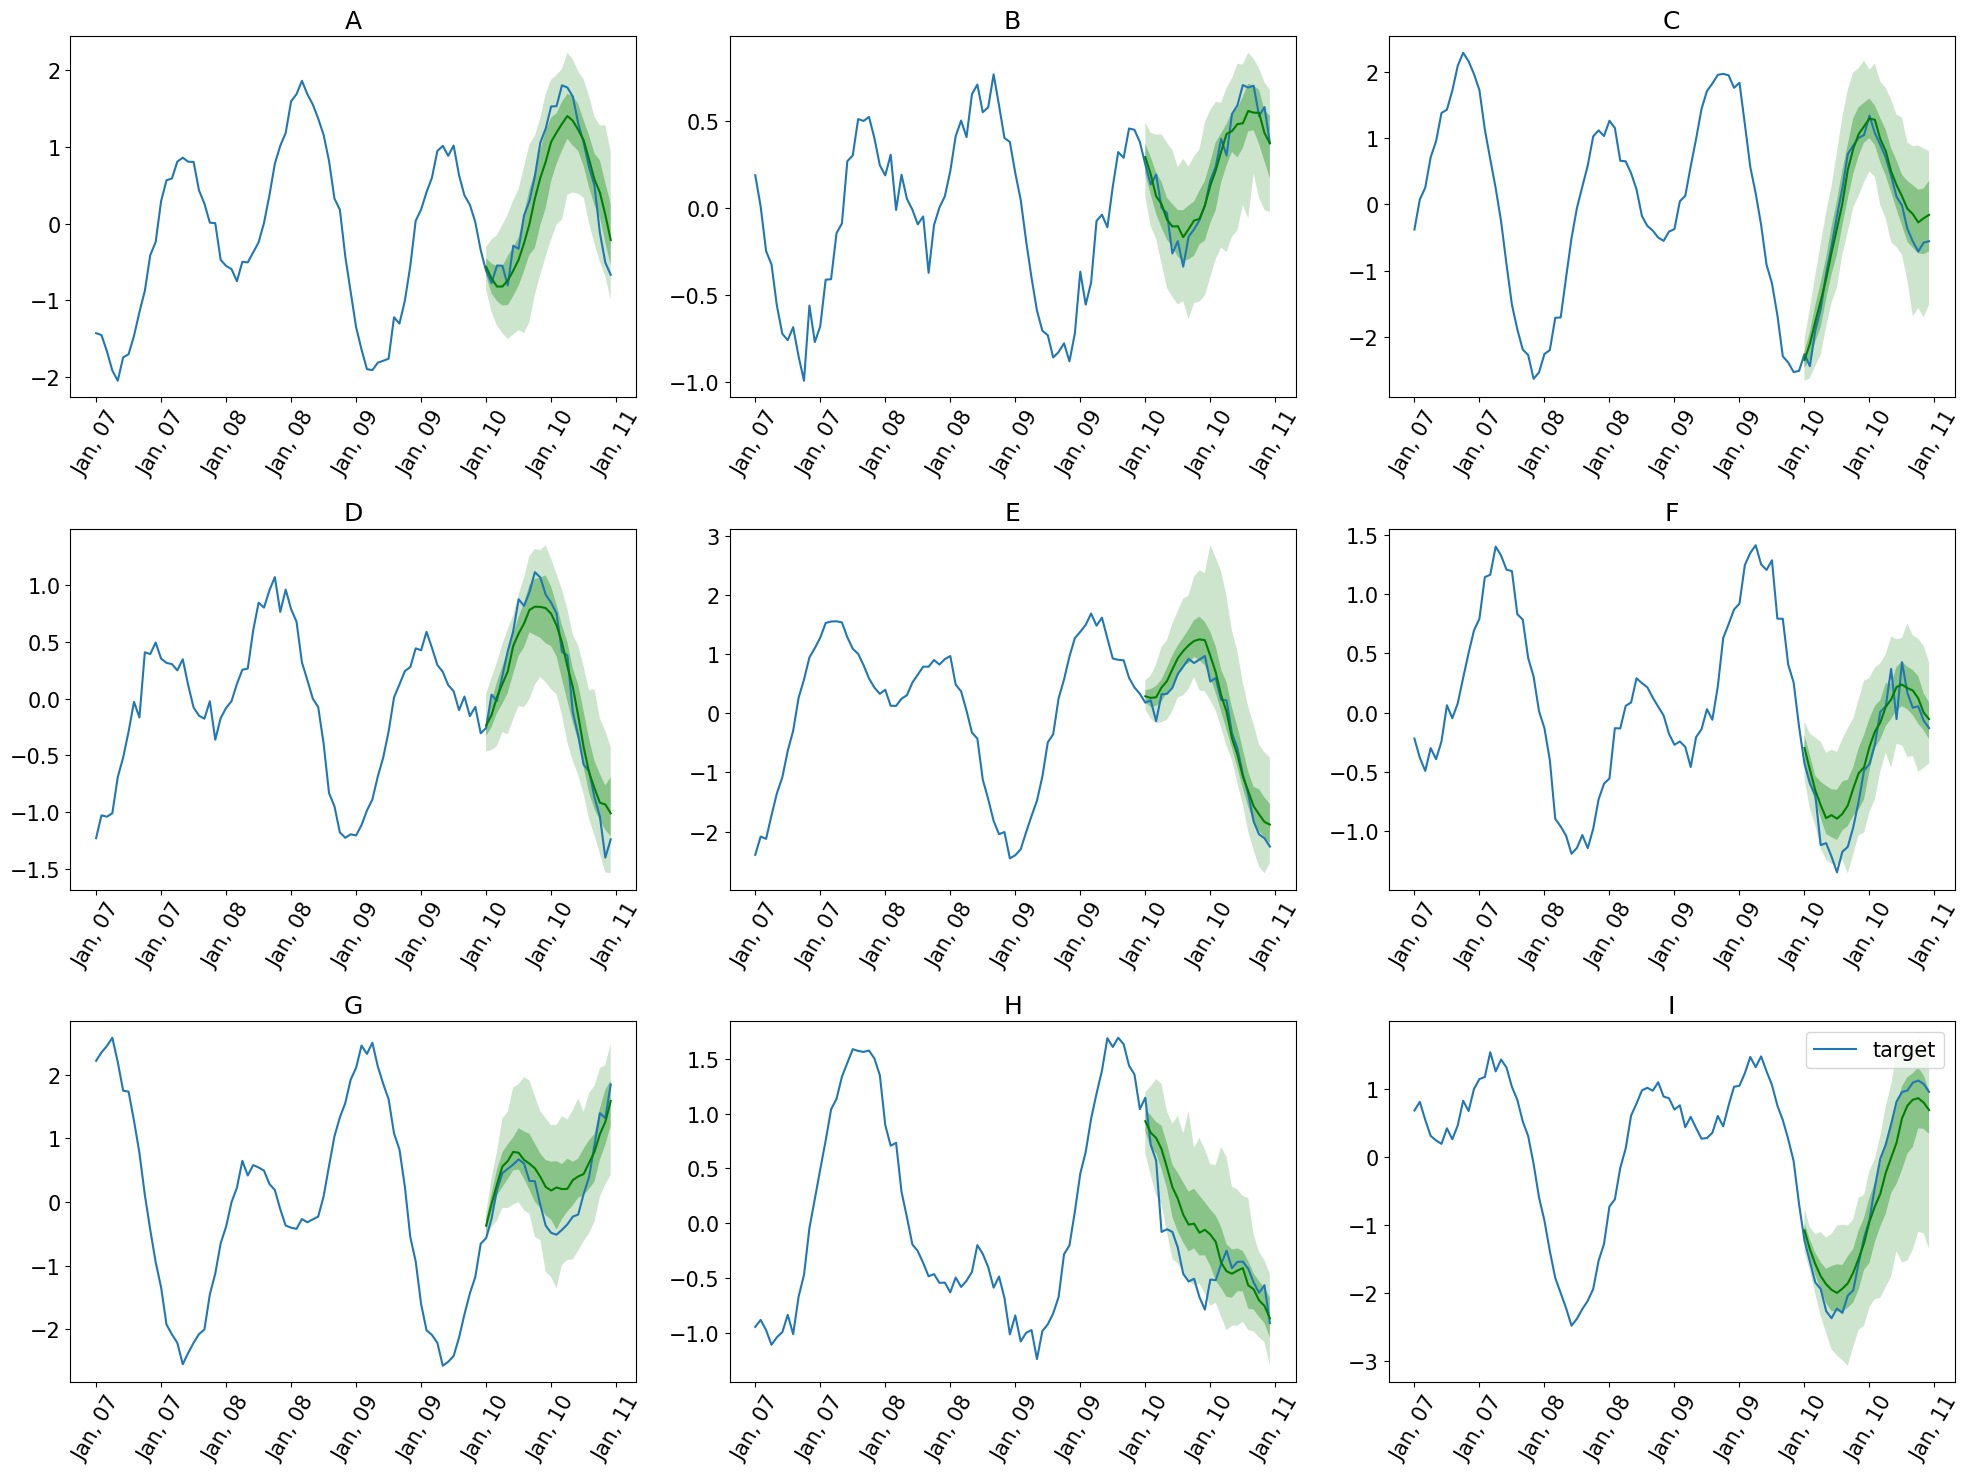

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Real Data test

Subamos nuestro archivo de prueba al entorno de trabajo

In [ ]:
%ls ..

David_prueba.csv  lag-llama/  sample_data/


In [ ]:
%pwd

'/content/lag-llama'

In [ ]:
%cp ../David_prueba.csv ./

In [ ]:
%ls

data/             gluon_utils/  lag_llama/       LICENSE    requirements.txt
David_prueba.csv  images/       lag-llama.ckpt@  README.md


In [181]:
df = pd.read_csv('David_prueba.csv',sep=",", parse_dates=['timestamp'])
#df.index = pd.to_datetime(df.index).normalize()
#df.index = pd.to_datetime(df.index).dt.floor('D')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%dT00:00:00')
#indices= list(df.timestamp.values)
#df= df.drop(columns=['timestamp'])
#df.index = indices
print(df.dtypes)
is_filter=list(df.item_id.unique()[0:9])
df=df[df['item_id'].isin(is_filter)]
#df=df.set_index('timestamp')
df

item_id      object
timestamp    object
target        int64
dtype: object


,item_id,timestamp,target
0,CHEMISSE PIÑA & COCO_10119,2022-01-10T00:00:00,1
1,CHEMISSE PIÑA & COCO_10119,2022-01-17T00:00:00,1
2,CHEMISSE PIÑA & COCO_10119,2022-01-24T00:00:00,1
3,CHEMISSE PIÑA & COCO_10119,2022-01-31T00:00:00,1
4,CHEMISSE PIÑA & COCO_10119,2022-02-07T00:00:00,1
...,...,...,...
976,CHEMISSE PIÑA & COCO_11875,2024-01-01T00:00:00,8
977,CHEMISSE PIÑA & COCO_11875,2024-01-01T00:00:00,0
978,CHEMISSE PIÑA & COCO_11875,2024-01-08T00:00:00,1
979,CHEMISSE PIÑA & COCO_11875,2024-01-15T00:00:00,3


In [182]:
def calculate_real_time(group):
    min_date = group['timestamp'].min()
    num_periods = group.shape[0]
    group['real_time'] = pd.date_range(start=min_date, periods=num_periods, freq='W')
    return group

# Apply the function per item_id group
df_with_real_time = df.groupby('item_id').apply(calculate_real_time)
df.timestamp=list(df_with_real_time.real_time.values)

indices= list(df.timestamp.values)
df= df.drop(columns=['timestamp'])
df.index = indices

df

,item_id,target
2022-01-16,CHEMISSE PIÑA & COCO_10119,1
2022-01-23,CHEMISSE PIÑA & COCO_10119,1
2022-01-30,CHEMISSE PIÑA & COCO_10119,1
2022-02-06,CHEMISSE PIÑA & COCO_10119,1
2022-02-13,CHEMISSE PIÑA & COCO_10119,1
...,...,...
2024-01-14,CHEMISSE PIÑA & COCO_11875,8
2024-01-21,CHEMISSE PIÑA & COCO_11875,0
2024-01-28,CHEMISSE PIÑA & COCO_11875,1
2024-02-04,CHEMISSE PIÑA & COCO_11875,3


In [136]:
def normalize_target(group):
    group['target'] = (group['target'] - group['target'].min()) / (group['target'].max() - group['target'].min())
    return group

# Apply normalization per item_id
df_normalized = df.groupby('item_id').apply(normalize_target)
df['target']=df_normalized.target.values
df

,item_id,target
2022-01-10T00:00:00,CHEMISSE PIÑA & COCO_10119,0.018519
2022-01-17T00:00:00,CHEMISSE PIÑA & COCO_10119,0.018519
2022-01-24T00:00:00,CHEMISSE PIÑA & COCO_10119,0.018519
2022-01-31T00:00:00,CHEMISSE PIÑA & COCO_10119,0.018519
2022-02-07T00:00:00,CHEMISSE PIÑA & COCO_10119,0.018519
...,...,...
2024-01-01T00:00:00,CHEMISSE PIÑA & COCO_10401,0.033333
2024-01-01T00:00:00,CHEMISSE PIÑA & COCO_10401,0.033333
2024-01-08T00:00:00,CHEMISSE PIÑA & COCO_10401,0.033333
2024-01-15T00:00:00,CHEMISSE PIÑA & COCO_10401,0.033333


In [183]:
df.isnull().sum()

item_id    0
target     0
dtype: int64

In [184]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 12  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

In [185]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

In [186]:
len(forecasts)

9

In [187]:
forecasts[0].samples.shape

(100, 12)

In [188]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id='CHEMISSE PIÑA & COCO_10119', samples=array([[ -0.93154526,  -0.49428487,   0.07814384, ...,   3.3621924 ,
           0.82058334,   3.0905404 ],
        [  2.1545644 ,  -0.2783296 ,   1.957329  , ...,   2.6938212 ,
           4.110277  ,   3.9431095 ],
        [ -0.607702  ,  -0.24557304,   1.7273579 , ...,   0.5716963 ,
          -3.0487928 ,  -6.078578  ],
        ...,
        [  2.4777186 ,   2.3424468 ,   3.1517403 , ...,   4.858672  ,
         -10.945417  , -14.94392   ],
        [  4.2637496 ,   0.7116709 ,   9.75315   , ...,   6.3455586 ,
           3.2706373 ,   3.4785156 ],
        [  2.8929832 ,   1.3997893 ,   2.1273522 , ...,  -1.2199025 ,
           0.0542438 ,  -0.73428965]], dtype=float32), start_date=Period('2023-11-20/2023-11-26', 'W-SUN')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='CHEMISSE PIÑA & COCO_10401', samples=array([[ 2.6190487e+01,  2.5947815e+01,  2.6346710e+01, ...,
         -3.0104

In [189]:
print(forecasts[0].item_id)
print(forecasts[0].samples.shape)
print(forecasts[0].samples) # 100 muestras de distirbucion para el forecast

CHEMISSE PIÑA & COCO_10119
(100, 12)
[[ -0.93154526  -0.49428487   0.07814384 ...   3.3621924    0.82058334
    3.0905404 ]
 [  2.1545644   -0.2783296    1.957329   ...   2.6938212    4.110277
    3.9431095 ]
 [ -0.607702    -0.24557304   1.7273579  ...   0.5716963   -3.0487928
   -6.078578  ]
 ...
 [  2.4777186    2.3424468    3.1517403  ...   4.858672   -10.945417
  -14.94392   ]
 [  4.2637496    0.7116709    9.75315    ...   6.3455586    3.2706373
    3.4785156 ]
 [  2.8929832    1.3997893    2.1273522  ...  -1.2199025    0.0542438
   -0.73428965]]


In [190]:
print(len(tss)) # data original
tss[0]

9


,0
2022-01-10/2022-01-16,1.0
2022-01-17/2022-01-23,1.0
2022-01-24/2022-01-30,1.0
2022-01-31/2022-02-06,1.0
2022-02-07/2022-02-13,1.0
...,...
2024-01-08/2024-01-14,1.0
2024-01-15/2024-01-21,5.0
2024-01-22/2024-01-28,8.0
2024-01-29/2024-02-04,3.0


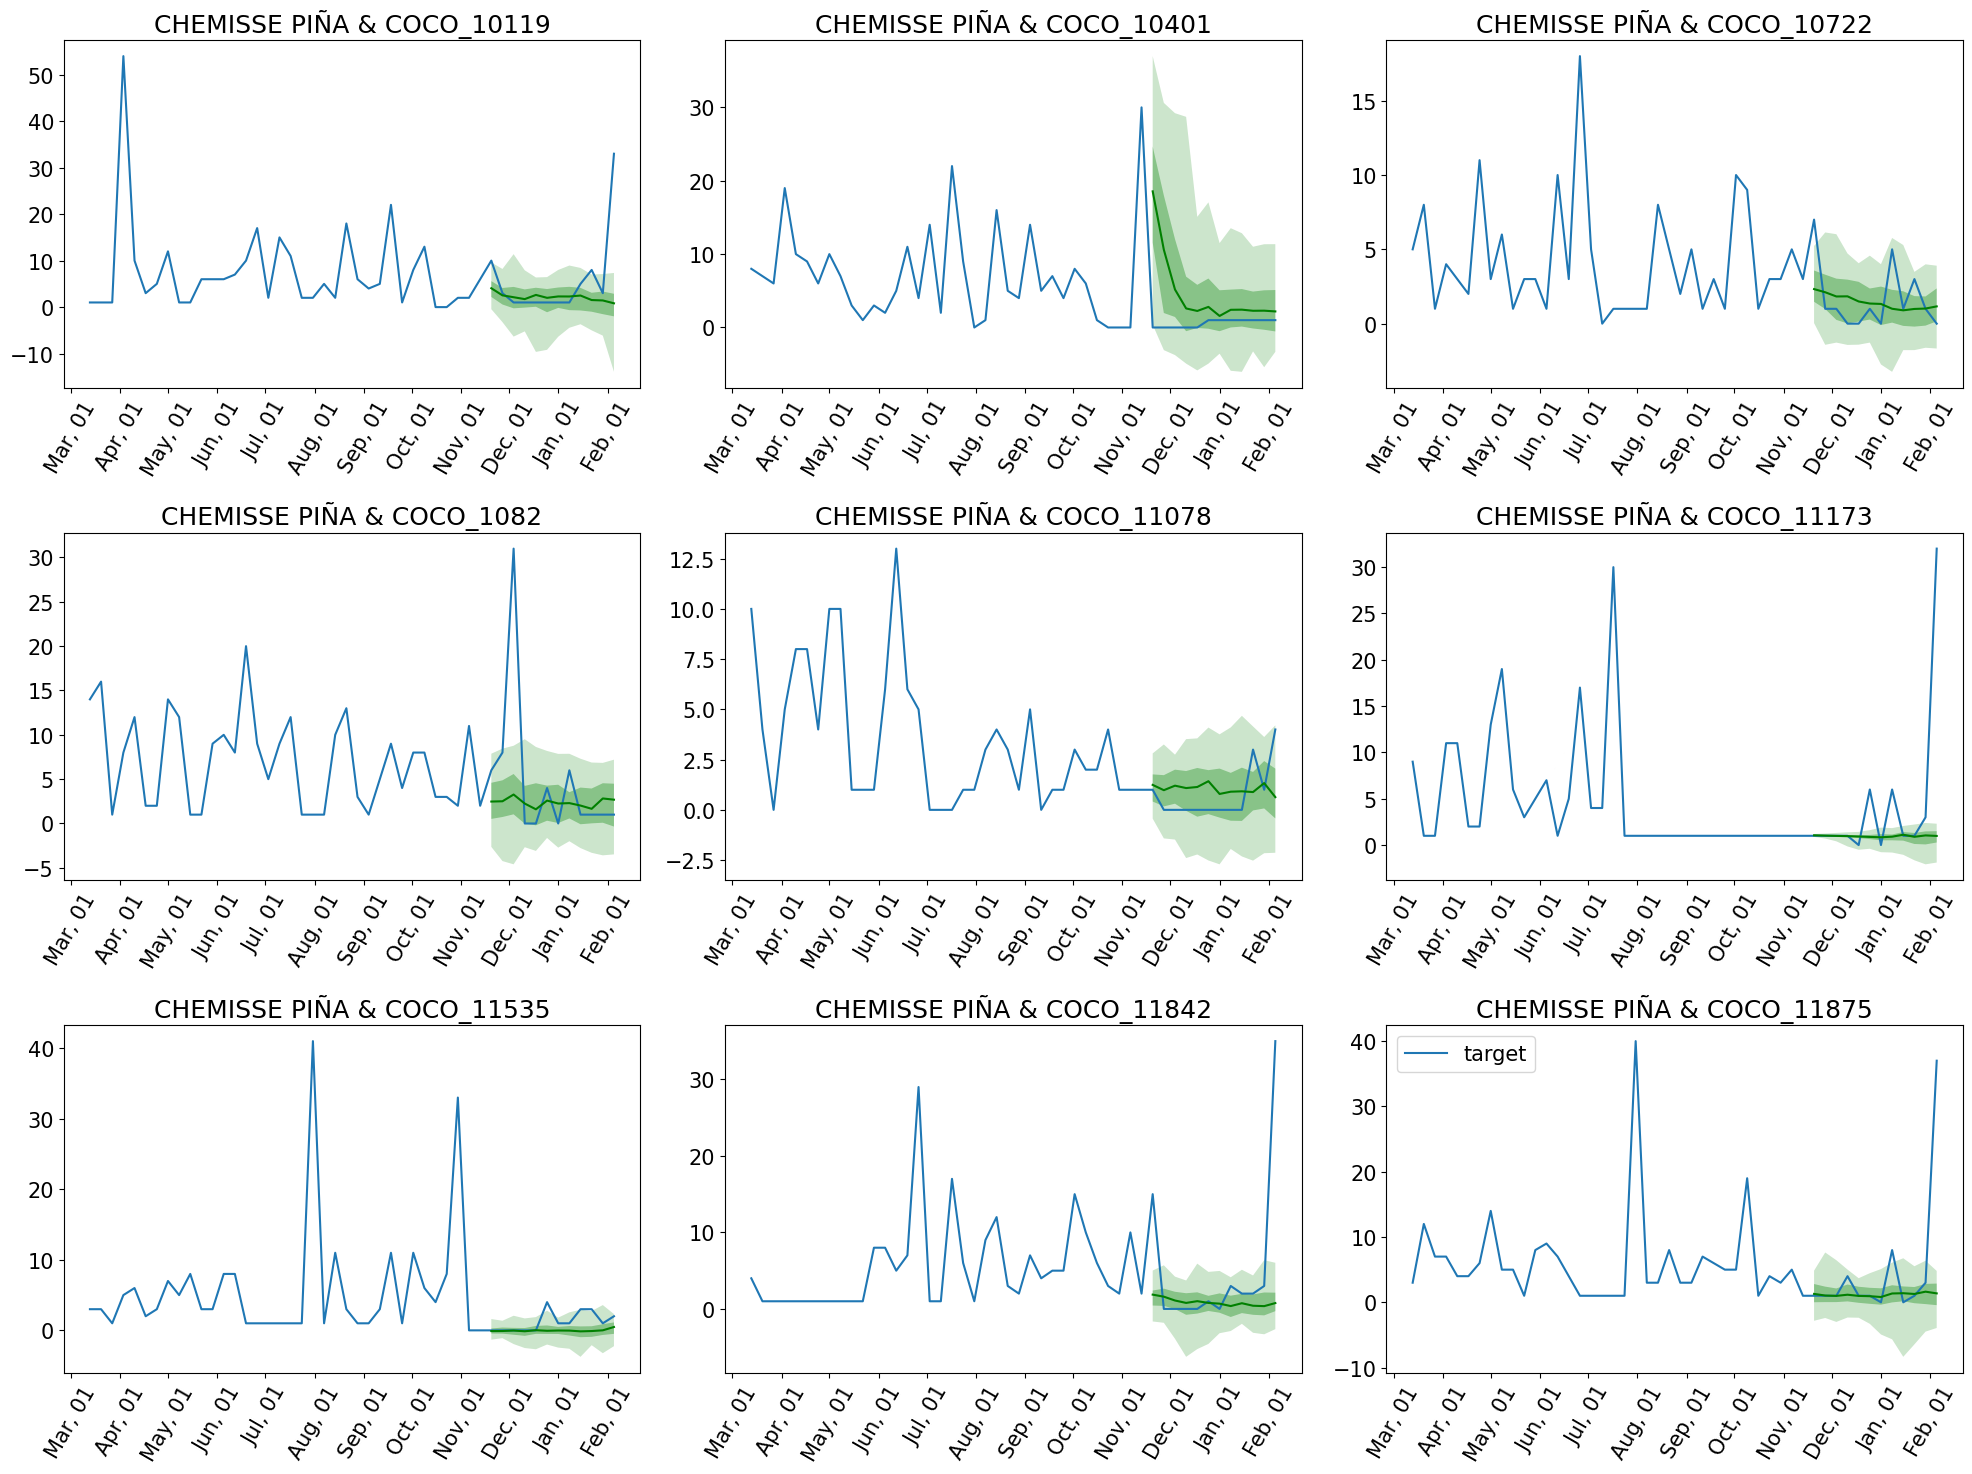

In [191]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

**Para predecir en realidad deberiamos introducir las fechas de interes en el csv con un valor ficticio y sobre el ultimo forecasthorizon los valores se adaptaran acorde**

# Real data complete

In [241]:
df = pd.read_csv('David_prueba.csv',sep=",", parse_dates=['timestamp'])
#df.index = pd.to_datetime(df.index).normalize()
#df.index = pd.to_datetime(df.index).dt.floor('D')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%dT00:00:00')
#indices= list(df.timestamp.values)
#df= df.drop(columns=['timestamp'])
#df.index = indices
print(df.dtypes)
is_filter=list(df.item_id.unique()[0:])
df=df[df['item_id'].isin(is_filter)]
#df=df.set_index('timestamp')
df

item_id      object
timestamp    object
target        int64
dtype: object


,item_id,timestamp,target
0,CHEMISSE PIÑA & COCO_10119,2022-01-10T00:00:00,1
1,CHEMISSE PIÑA & COCO_10119,2022-01-17T00:00:00,1
2,CHEMISSE PIÑA & COCO_10119,2022-01-24T00:00:00,1
3,CHEMISSE PIÑA & COCO_10119,2022-01-31T00:00:00,1
4,CHEMISSE PIÑA & COCO_10119,2022-02-07T00:00:00,1
...,...,...,...
18083,CORNETTO CHOCOLLAGE_14525,2024-01-01T00:00:00,1
18084,CORNETTO CHOCOLLAGE_14525,2024-01-01T00:00:00,1
18085,CORNETTO CHOCOLLAGE_14525,2024-01-08T00:00:00,0
18086,CORNETTO CHOCOLLAGE_14525,2024-01-15T00:00:00,0


In [242]:
def calculate_real_time(group):
    min_date = group['timestamp'].min()
    num_periods = group.shape[0]
    group['real_time'] = pd.date_range(start=min_date, periods=num_periods, freq='W')
    return group

# Apply the function per item_id group
df_with_real_time = df.groupby('item_id').apply(calculate_real_time)
df.timestamp=list(df_with_real_time.real_time.values)

indices= list(df.timestamp.values)
df= df.drop(columns=['timestamp'])
df.index = indices

df

,item_id,target
2022-01-16,CHEMISSE PIÑA & COCO_10119,1
2022-01-23,CHEMISSE PIÑA & COCO_10119,1
2022-01-30,CHEMISSE PIÑA & COCO_10119,1
2022-02-06,CHEMISSE PIÑA & COCO_10119,1
2022-02-13,CHEMISSE PIÑA & COCO_10119,1
...,...,...
2024-01-14,CORNETTO CHOCOLLAGE_14525,1
2024-01-21,CORNETTO CHOCOLLAGE_14525,1
2024-01-28,CORNETTO CHOCOLLAGE_14525,0
2024-02-04,CORNETTO CHOCOLLAGE_14525,0


In [243]:

def normalize_target(group):
    group['target'] = (group['target'] - group['target'].min()) / (group['target'].max() - group['target'].min())
    return group

# Apply normalization per item_id
df_normalized = df.groupby('item_id').apply(normalize_target)
df['target']=df_normalized.target.values
df

,item_id,target
2022-01-16,CHEMISSE PIÑA & COCO_10119,0.018519
2022-01-23,CHEMISSE PIÑA & COCO_10119,0.018519
2022-01-30,CHEMISSE PIÑA & COCO_10119,0.018519
2022-02-06,CHEMISSE PIÑA & COCO_10119,0.018519
2022-02-13,CHEMISSE PIÑA & COCO_10119,0.018519
...,...,...
2024-01-14,CORNETTO CHOCOLLAGE_14525,0.041667
2024-01-21,CORNETTO CHOCOLLAGE_14525,0.041667
2024-01-28,CORNETTO CHOCOLLAGE_14525,0.000000
2024-02-04,CORNETTO CHOCOLLAGE_14525,0.000000


In [244]:
df.isnull().sum()

item_id    0
target     0
dtype: int64

In [245]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 12  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

In [246]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

In [198]:
len(forecasts)

200

In [247]:
forecasts[0].samples.shape

(100, 12)

In [248]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id='CHEMISSE PIÑA & COCO_10119', samples=array([[ 0.09817141,  0.102414  ,  0.08476812, ..., -0.1312765 ,
         -0.13305512, -0.12120947],
        [ 0.09139341,  0.07984686, -0.12164564, ...,  0.04669102,
          0.0348244 ,  0.0303831 ],
        [ 0.0354516 ,  0.03736388,  0.08079538, ...,  0.06364807,
          0.00832289,  0.01195238],
        ...,
        [ 0.21886384, -0.12504555,  0.11720414, ...,  0.09545578,
          0.09633072,  0.07742625],
        [ 0.2117379 ,  0.22760521,  0.5516229 , ..., -0.46435884,
         -0.03001658,  0.0076403 ],
        [ 0.01257289, -0.00769035,  0.04425969, ..., -0.01096651,
          0.03119753,  0.0534961 ]], dtype=float32), start_date=Period('2023-11-20/2023-11-26', 'W-SUN')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='CHEMISSE PIÑA & COCO_10401', samples=array([[ 0.16812304,  0.24027222,  0.183369  , ...,  0.11794835,
          0.2440117 ,  0.1449022 ],
        [ 0.

In [250]:
import numpy as np
def accuracy(y_true, y_pred):
  return (1 -((np.abs(y_true-y_pred))/y_true))*100
acc=[]

series=list(df.item_id.unique())
for i in series[0:]:
  #print(i==forecasts[0].item_id)
  reals=df.query(f"item_id=='{i}'").iloc[-prediction_length:].target.values
  reals[reals<=0] =np.nan
  fcst= np.nanmedian(forecasts[0].samples,axis=0)
  fcst[fcst<=0] =np.nan
  acc.append(np.nanmean(accuracy(y_true=reals, y_pred=fcst)))
  print('Serie:', i, '-- Accuracy:', np.nanmean(accuracy(y_true=reals, y_pred=fcst)))
  print('ACC GLOBAL: ', np.nanmean(acc))

Serie: CHEMISSE PIÑA & COCO_10119 -- Accuracy: -22.117142
ACC GLOBAL:  -22.117142
Serie: CHEMISSE PIÑA & COCO_10401 -- Accuracy: 58.036682
ACC GLOBAL:  17.95977
Serie: CHEMISSE PIÑA & COCO_10722 -- Accuracy: 62.92831
ACC GLOBAL:  32.949284
Serie: CHEMISSE PIÑA & COCO_1082 -- Accuracy: 44.638523
ACC GLOBAL:  35.871593
Serie: CHEMISSE PIÑA & COCO_11078 -- Accuracy: 45.85565
ACC GLOBAL:  37.868404
Serie: CHEMISSE PIÑA & COCO_11173 -- Accuracy: 23.14743
ACC GLOBAL:  35.41491
Serie: CHEMISSE PIÑA & COCO_11535 -- Accuracy: 38.098644
ACC GLOBAL:  35.7983
Serie: CHEMISSE PIÑA & COCO_11842 -- Accuracy: 41.70374
ACC GLOBAL:  36.53648
Serie: CHEMISSE PIÑA & COCO_11875 -- Accuracy: -5.7286606
ACC GLOBAL:  31.840353
Serie: CHEMISSE PIÑA & COCO_11947 -- Accuracy: 36.628403
ACC GLOBAL:  32.31916
Serie: CHEMISSE PIÑA & COCO_11981 -- Accuracy: 55.863724
ACC GLOBAL:  34.45957
Serie: CHEMISSE PIÑA & COCO_12529 -- Accuracy: 39.557148
ACC GLOBAL:  34.884373
Serie: CHEMISSE PIÑA & COCO_12676 -- Accuracy: 44

<ipython-input-250-c76c347007cb>:13: RuntimeWarning: Mean of empty slice
  acc.append(np.nanmean(accuracy(y_true=reals, y_pred=fcst)))
<ipython-input-250-c76c347007cb>:14: RuntimeWarning: Mean of empty slice
  print('Serie:', i, '-- Accuracy:', np.nanmean(accuracy(y_true=reals, y_pred=fcst)))


Serie: CHOCOMILK_9471 -- Accuracy: 45.646057
ACC GLOBAL:  31.798248
Serie: COPA CORNETTO FRESAS CON CREMA_11593 -- Accuracy: 20.214188
ACC GLOBAL:  31.700903
Serie: COPA CORNETTO FRESAS CON CREMA_14362 -- Accuracy: 26.291391
ACC GLOBAL:  31.655825
Serie: COPA CORNETTO FRESAS CON CREMA_14761 -- Accuracy: 47.901405
ACC GLOBAL:  31.790085
Serie: COPA CORNETTO FRESAS CON CREMA_15105 -- Accuracy: 26.253513
ACC GLOBAL:  31.744703
Serie: COPA CORNETTO FRESAS CON CREMA_15873 -- Accuracy: 51.101665
ACC GLOBAL:  31.902077
Serie: COPA CORNETTO FRESAS CON CREMA_16793 -- Accuracy: 31.700132
ACC GLOBAL:  31.900448
Serie: COPA CORNETTO FRESAS CON CREMA_18213 -- Accuracy: 22.503012
ACC GLOBAL:  31.82527
Serie: COPA CORNETTO FRESAS CON CREMA_18932 -- Accuracy: nan
ACC GLOBAL:  31.82527
Serie: COPA CORNETTO FRESAS CON CREMA_19943 -- Accuracy: 19.007477
ACC GLOBAL:  31.72354
Serie: COPA CORNETTO FRESAS CON CREMA_20087 -- Accuracy: 59.020515
ACC GLOBAL:  31.938477
Serie: COPA CORNETTO FRESAS CON CREMA_264

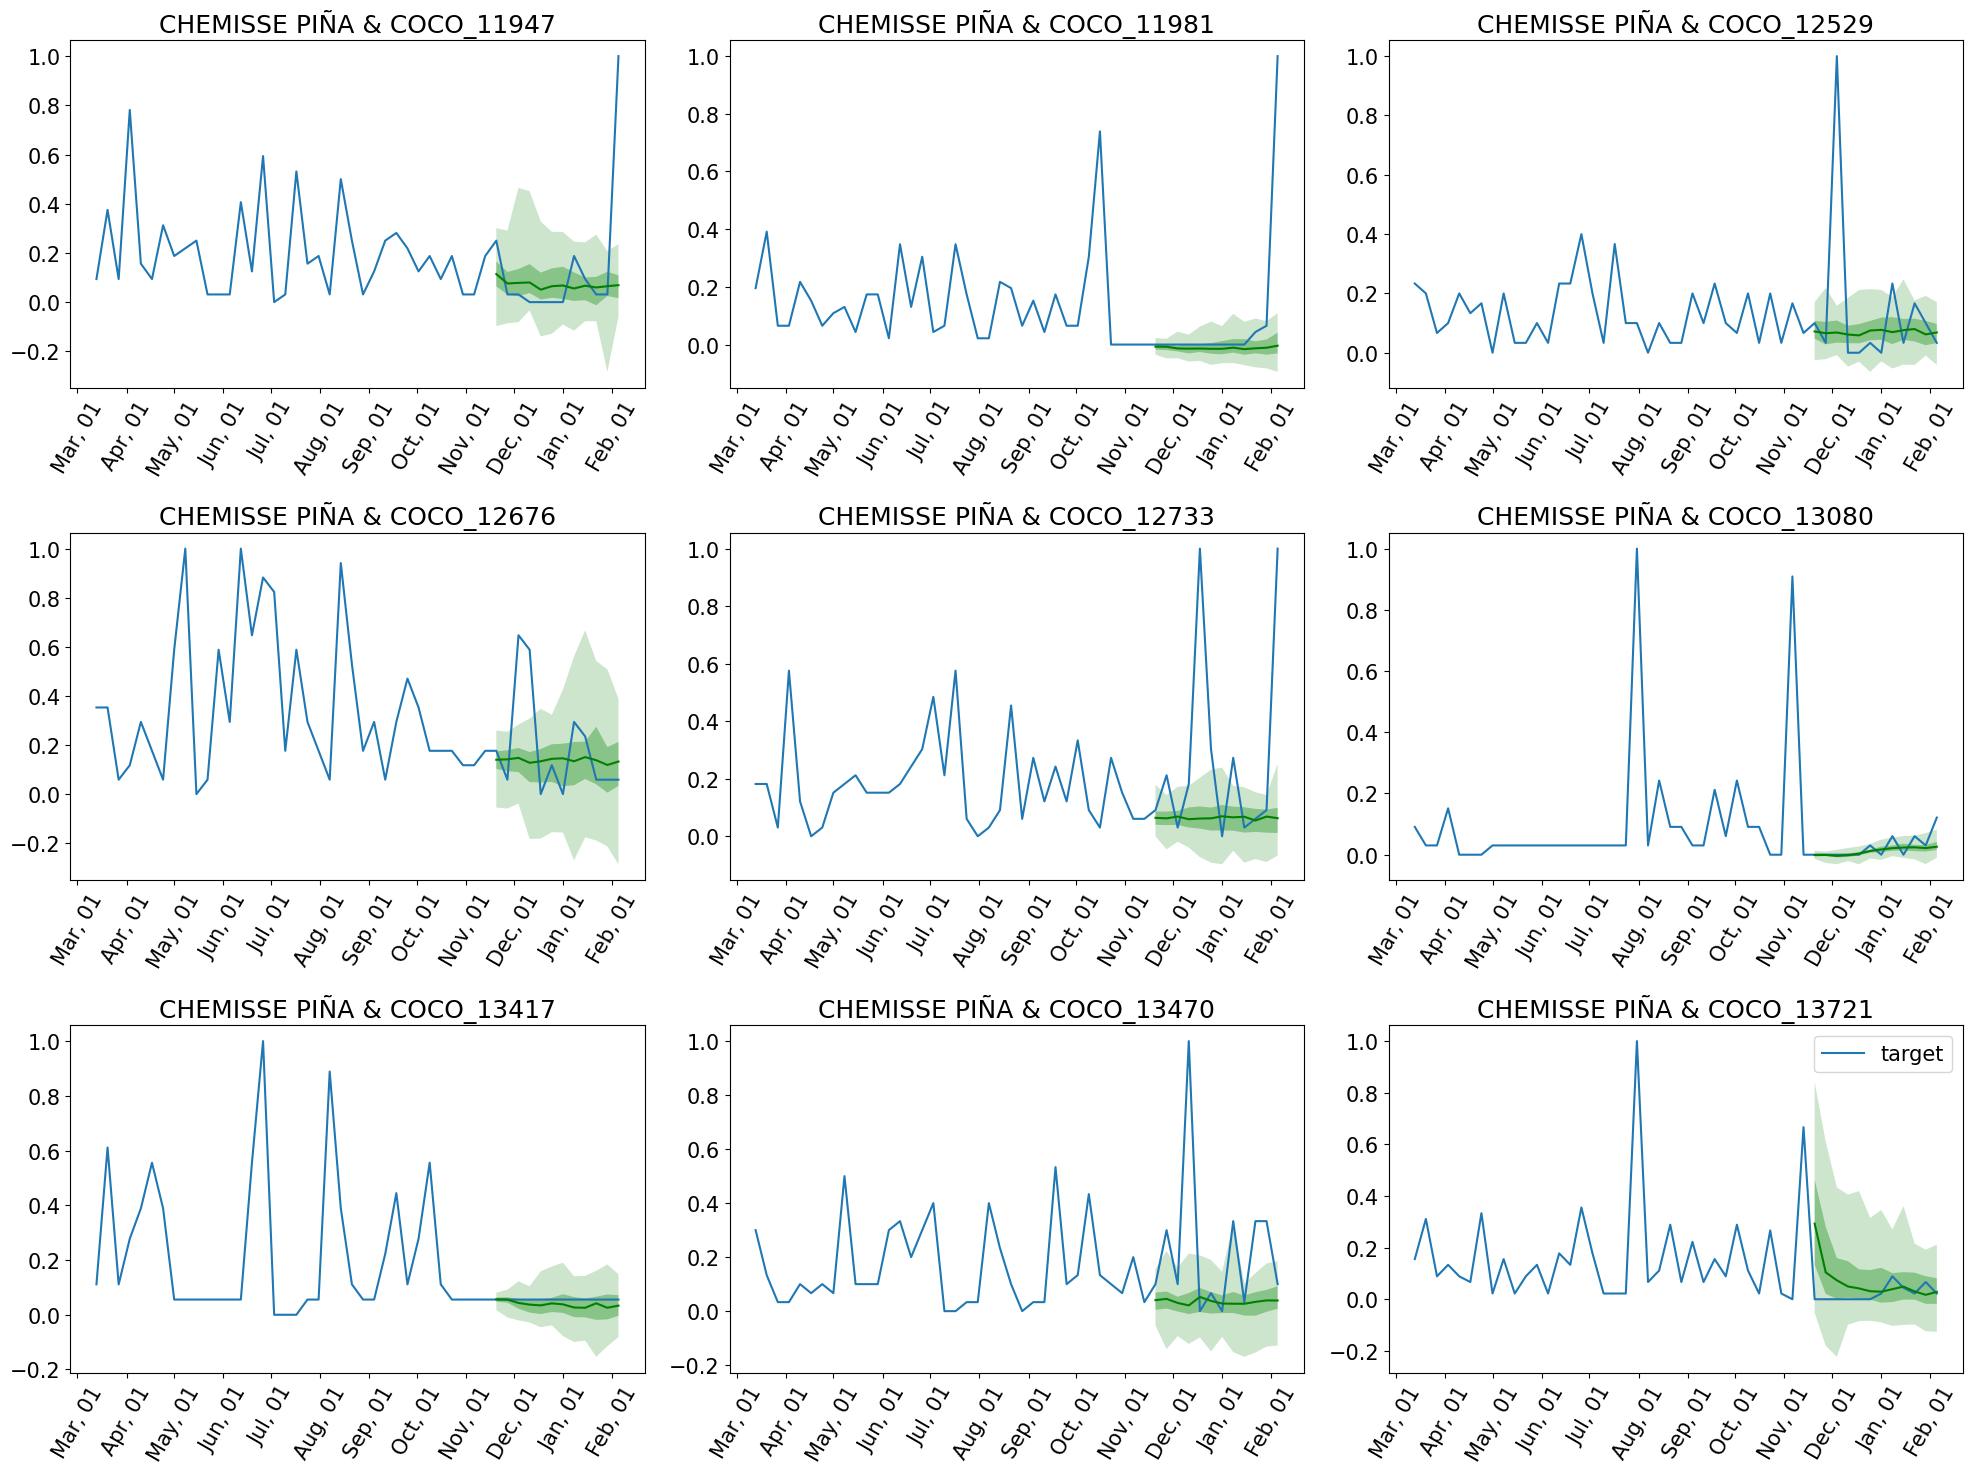

In [251]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts[9:18], tss[9:18])), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

**Para predecir en realidad deberiamos introducir las fechas de interes en el csv con un valor ficticio y sobre el ultimo forecasthorizon los valores se adaptaran acorde**